In [1]:
from asteval import Interpreter

import matplotlib.pyplot as pl
import matplotlib as mpl
%matplotlib notebook

import astropy.units as u
import astropy.io.fits as fits
from astropy.utils.data import download_file
from astropy.nddata import StdDevUncertainty

import astropy.modeling.models as models

from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

## Read spectrum data

This step is outside the scope of the backend. The UI is assumed to feed the spectrum data to the backed via a properly intialized Spectrum1D instance. 

In [2]:
# fn = download_file('https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/7495/stack/manga-7495-12704-LOGCUBE.fits.gz', cache=True)
fn = download_file('file:/Users/busko/Downloads/manga-7495-12704-LOGCUBE.fits', cache=True)
f = fits.open(fn)

flux = f[1].data
err = f[2].data
wave = f[4].data

In [3]:
# Units handling is presumed to come from above, perhaps at the loader level?
# Here we pretend we got them already somehow
funit_string = f[1].header['BUNIT']
funit = u.def_unit(funit_string, 1.E-17 * u.erg/u.s/u.cm/u.cm/u.Angstrom)
u.add_enabled_units([funit])
wunit = u.Unit('Angstrom')

flux = flux[:,35,35] * funit
err = err[:,35,35] * funit
wave = wave * wunit

spectrum = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=StdDevUncertainty(err))

# The spectrum may be already clipped or masked or otherwise pre-processed by 
# other functionality available outside the fitting plugin. Here, we pretened 
# it was limited to a small region.
region = SpectralRegion(6500*wunit, 7000*wunit)

# The object the backend expects via its API.
spectrum = extract_region(spectrum, region)

### Visual check

<IPython.core.display.Javascript object>


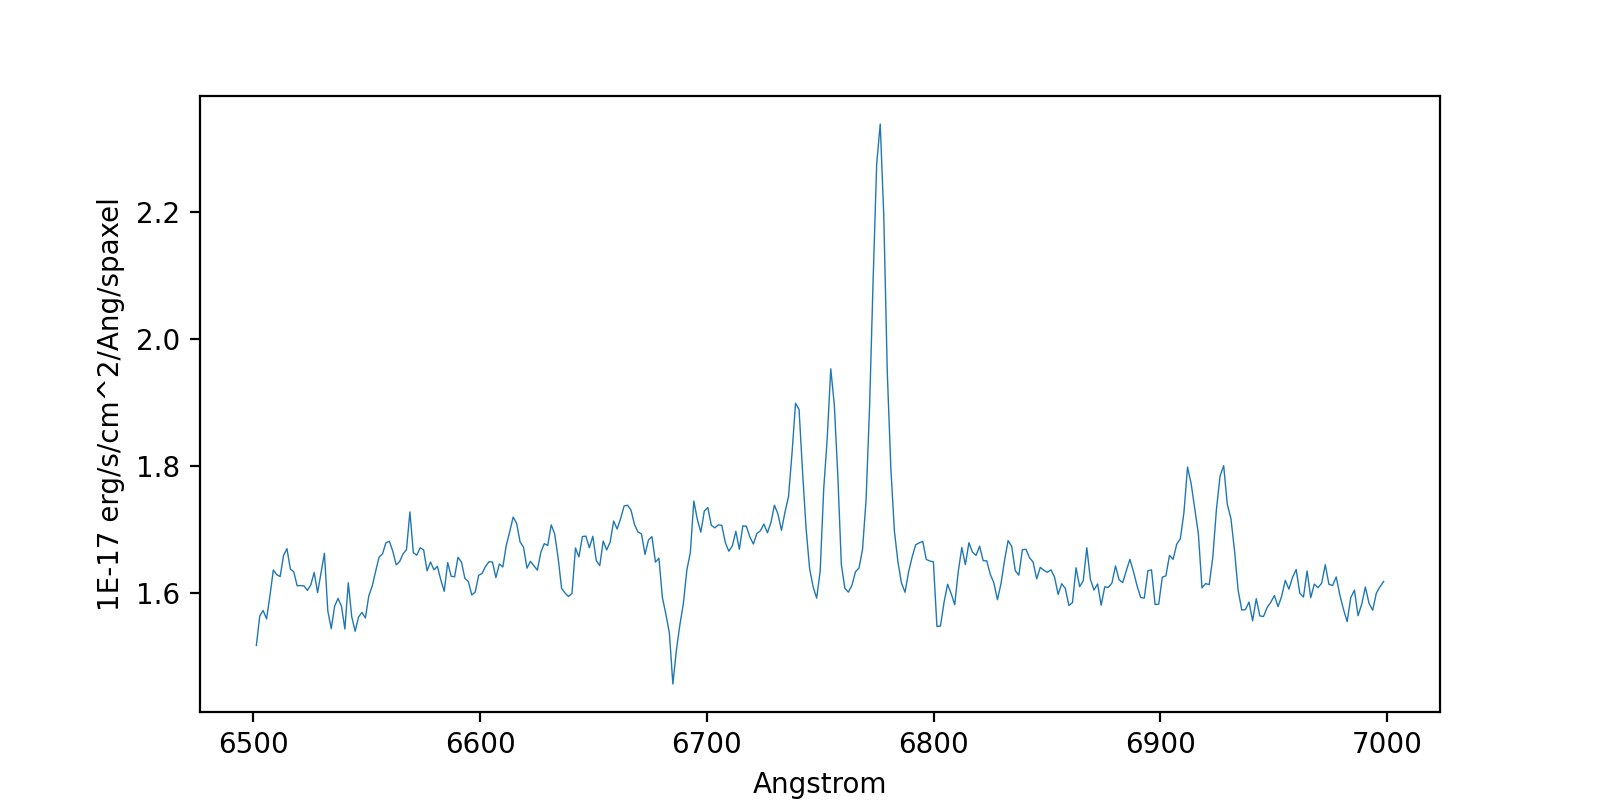

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/spaxel')

In [4]:
pl.figure()
pl.gcf().set_size_inches((8.,4.))
pl.plot(spectrum.spectral_axis, spectrum.flux, linewidth=0.5, label='obs')
pl.xlabel(str(spectrum.spectral_axis.unit))
pl.ylabel(str(spectrum.flux.unit))

## Read model from UI

The UI is assumed to feed an instance of an Astropy compound model, plus an arithmetic expression, to the backed API.  

In [5]:
# Model subcomponents come from a list or similar, generated by the UI. The UI
# is expected to initialize each subcomponent down to the level of optional
# properties such as the fixed and tied parameters, subcomponent names, and such.
#
# Here, we pretend and generate them by hand.
g1 = models.Gaussian1D(amplitude=0.7*funit, mean=6776.*wunit, stddev=3*wunit, name='g1')
g2 = models.Gaussian1D(amplitude=0.5*funit, mean=6755.*wunit, stddev=3*wunit, name='g2')
g3 = models.Gaussian1D(amplitude=0.4*funit, mean=6740.*wunit, stddev=3*wunit, name='g3')
zero_level = models.Const1D(amplitude=1.*funit, name='const1d')
# ...
# ... 
# other additional components...

# The second part of the model is the arithmetic expression. 
# The UI feeds this string to the backend.
expression = "g1 + g2 + g3 + const1d"

# The expression parser needs the subcomponents stored in a dict, 
# with keys taken from their names. 
# This mechanism can be augmented with status feedback to the
# UI (see specviz/specviz/plugins/model_editor/models.py around
# lines 200-230)
model_dict = {g1.name:g1,
              g2.name:g2,
              g3.name:g3,
              zero_level.name:zero_level}
aeval = Interpreter(usersyms=model_dict)
compound_model_init = aeval(expression)

## Fit model

In [6]:
fitted_model = fit_lines(spectrum, compound_model_init)

In [7]:
fitted_values = fitted_model(spectrum.spectral_axis)

## Result

The backed returns to the UI the fitted model computed above, plus a model realization in the form of a Spectrum1D instance.  

In [8]:
fitted_spectrum = Spectrum1D(spectral_axis=spectrum.spectral_axis, flux=fitted_values*funit)

### Check result

In [9]:
fitted_model

<CompoundModel(amplitude_0=0.69740697 1E-17 erg/s/cm^2/Ang/spaxel, mean_0=6775.94993199 Angstrom, stddev_0=2.93701335 Angstrom, amplitude_1=0.31790169 1E-17 erg/s/cm^2/Ang/spaxel, mean_1=6754.8380952 Angstrom, stddev_1=2.10640416 Angstrom, amplitude_2=0.25044252 1E-17 erg/s/cm^2/Ang/spaxel, mean_2=6739.16814777 Angstrom, stddev_2=2.96101437 Angstrom, amplitude_3=1.63747228 1E-17 erg/s/cm^2/Ang/spaxel)>

<IPython.core.display.Javascript object>


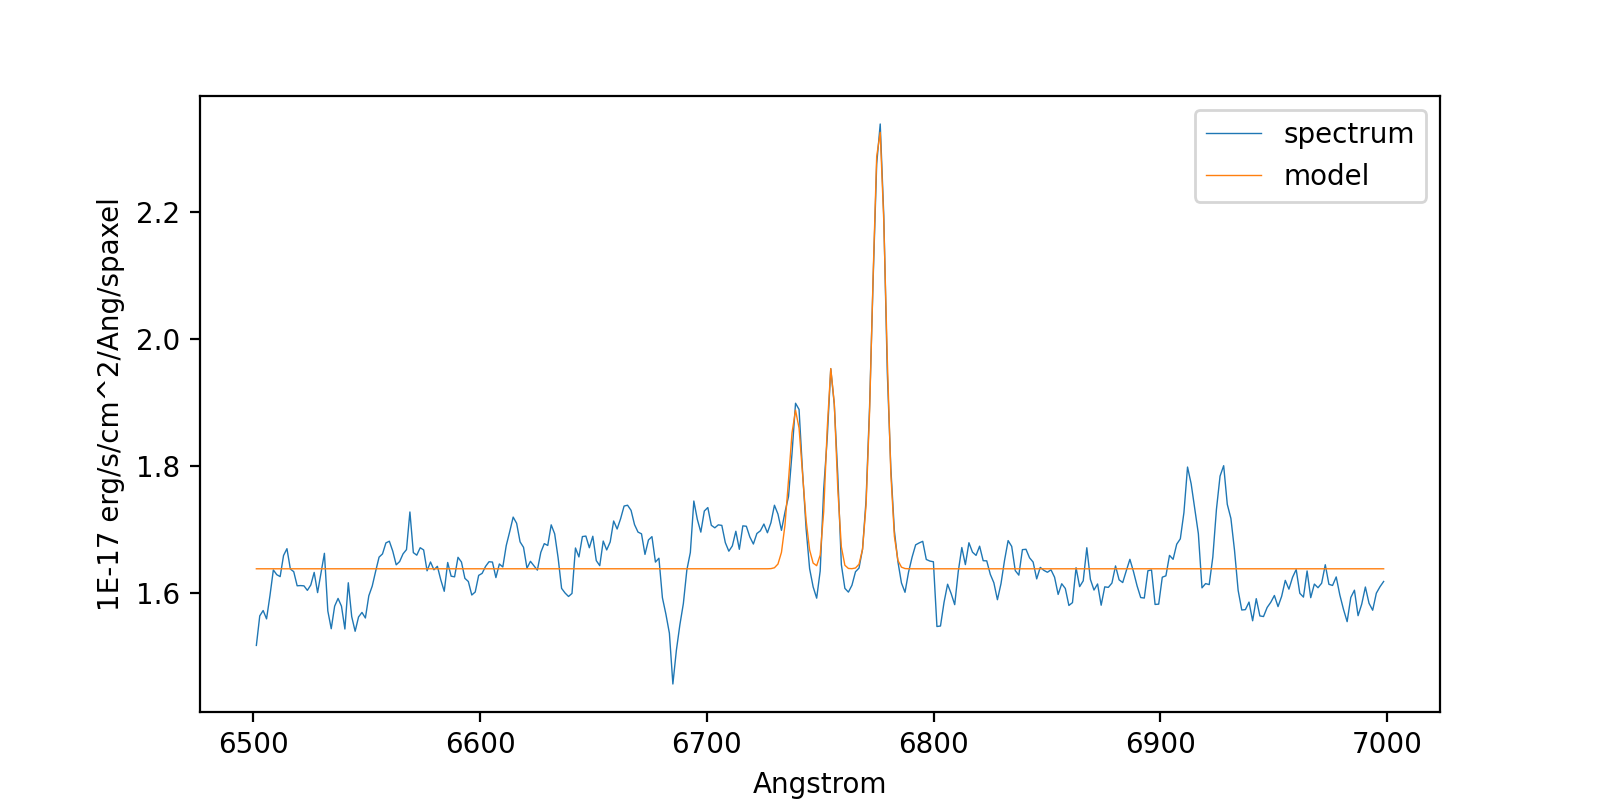

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/spaxel')

In [10]:
pl.figure()
pl.gcf().set_size_inches((8.,4.))
pl.plot(spectrum.spectral_axis, spectrum.flux, linewidth=0.5, label='spectrum')
pl.plot(spectrum.spectral_axis, fitted_values, linewidth=0.5, label='model')
pl.legend()
pl.xlabel(str(spectrum.spectral_axis.unit))
pl.ylabel(str(spectrum.flux.unit))

## Backend code in a module

The backend code performs the steps above (read spectrum and model from UI, performs fit) and will live in a module. Here is an example. Although the API still neeeds to be defined in detail. E.g. parameters such as fit windows, regions, fitter parameters and the like still need to be passed via API. 

In [11]:
from jdaviz.configs.default.plugins.model_fitting import fitting_backend as fb

model_list = [g1,g2,g3,zero_level]
fitted_model, fitted_spectrum = fb.fit_model_to_spectrum(spectrum, model_list, expression)

### Verify results from the backend implementation

<IPython.core.display.Javascript object>


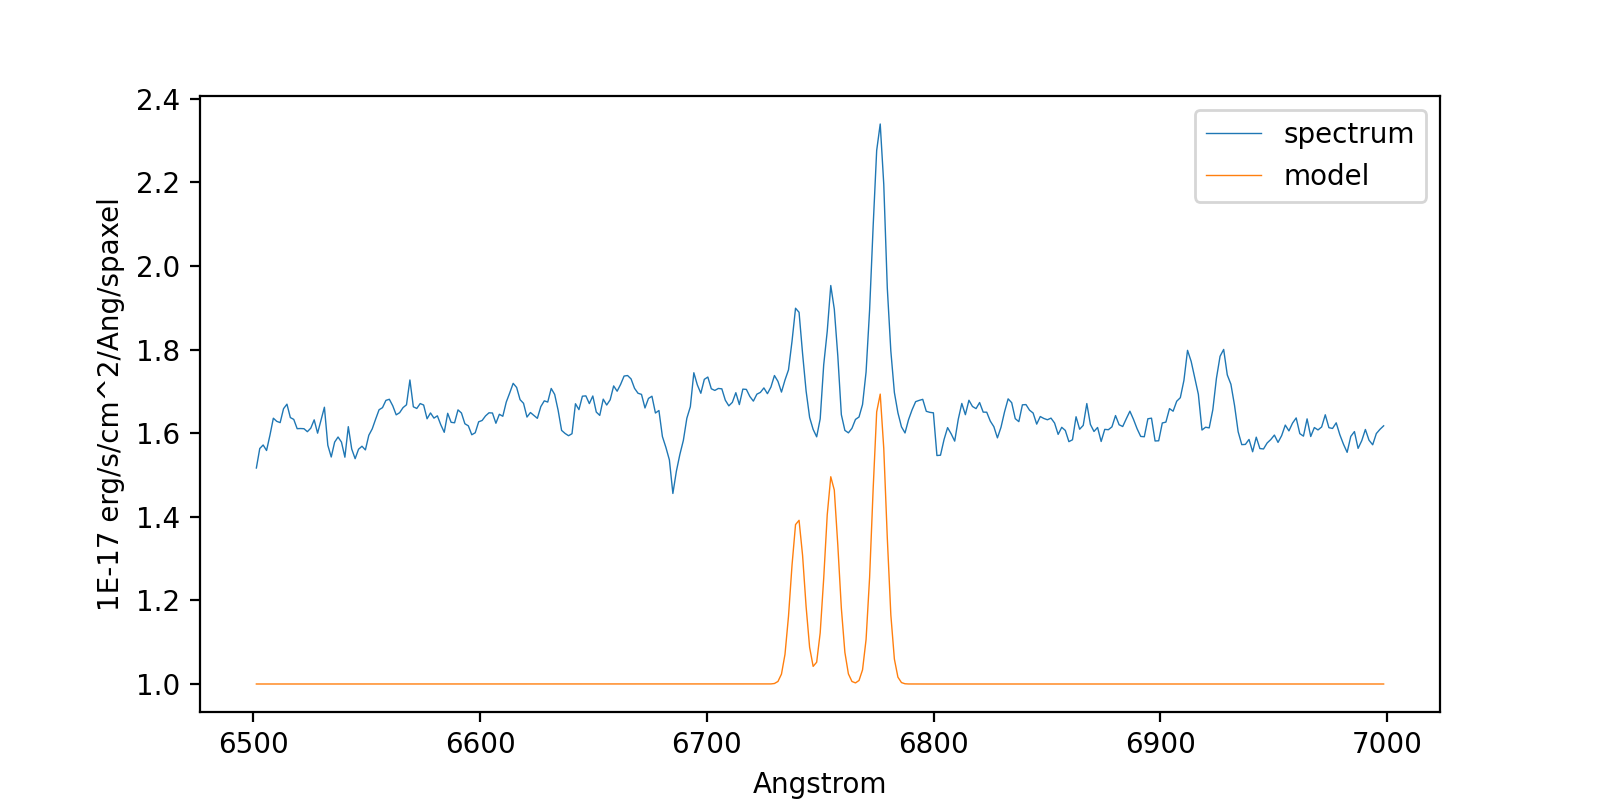

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/spaxel')

In [12]:
pl.figure()
pl.gcf().set_size_inches((8.,4.))
pl.plot(spectrum.spectral_axis, spectrum.flux, linewidth=0.5, label='spectrum')
pl.plot(spectrum.spectral_axis, fitted_spectrum.flux.value, linewidth=0.5, label='model')
pl.legend()
pl.xlabel(str(spectrum.spectral_axis.unit))
pl.ylabel(str(spectrum.flux.unit))